<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 Pytorch Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [ ]:
# Set your student number
student_number = 98101822
Name = 'یلدا'
Last_Name = 'شعبان زاده'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Rules
- You **are** allowed to add or remove cells. 
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [ ]:
import sys

address = 'AI/MPQ4/Practical'
sys.path.append(f'content/drive/MyDrive/{address}')

% cd /content/drive/MyDrive/$address

/content/drive/MyDrive/AI/MPQ4/Practical


In [ ]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q2.ipynb")
with open(f'python_code_Q2_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# PyTorch & MNIST Classification (50 points+5 Extra)

<font size=4>
Author: Arman Zarei
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this assignment, you are going to learn the fundamentals of PyTorch and implement a classifier network for MNIST dataset. You can read about more details of PyTorch components from [this link](https://pytorch.org/tutorials).

### Setup

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from  Helper_codes.ae_helper import init_mnist_subset_directories

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Loading dataset

In [ ]:
mnist_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

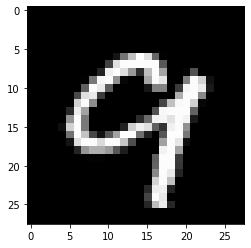

In [ ]:
import random


train, test = mnist_dataset[random.randint(0, len(mnist_dataset) - 1)]
plt.imshow(train[0], cmap='gray')

## Autograd

Autograd is PyTorch's automatic differentiation engine that powers neural network training. In essence it helps us to calculate derivatives and updating parameters. To read more about Autograd and Computational Graph visit [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let us define two parameters: $p_1$ and $p_2$. 

In [ ]:
p1 = torch.tensor([3.], requires_grad=True)
p2 = torch.tensor([7.], requires_grad=True)

Now define a variable $L$ as below:

$L = 3 \times p_1^3 - 7 \times p_2^2 + sin(p1) \times p_2^2$

In [ ]:
L = 3 * pow(p1, 3) - 7 * pow(p2, 2) + torch.sin(p1) * pow(p2, 2)
L

tensor([-255.0851], grad_fn=<AddBackward0>)

Now you have to calculate the gradient of $p_1$ and $p_2$ with respect to $L$. First do it by hand and write the mathematical expression in the below cell both for $p_1$ and $p_2$. Then evaluate them at $3$ and $7$ (acording to the initialization)

Place your expressions here **(2.5 Points)**


$\frac{dL}{dp_1} = 9 \times {p_1} ^ 2 + cos({p_1}) \times {p_2} ^ 2$ 

$\frac{dL}{dp_2} = -14 \times {p_2}  + 2 \times sin({p_1}) \times {p_2}$

$\frac{dL}{dp_1}(3, 7) = 32.4904$

$\frac{dL}{dp_2}(3, 7) = -96.0243$

In [ ]:
def get_partial_derivatives(p1, p2):
    return (
        9 * pow(p1, 2) + torch.cos(p1) * pow(p2, 2),
        -14 * p2 + 2 * torch.sin(p1) * p2
    )

get_partial_derivatives(p1, p2)

(tensor([32.4904], grad_fn=<AddBackward0>),
 tensor([-96.0243], grad_fn=<AddBackward0>))

Now let's calculate this using pytorch. The below code will construct the computational graph and stores the gradient of each variable inside of it.

In [ ]:
L.backward()

Check whether the result of your calculations is the same with the autograd's output.

In [ ]:
print(f"P_1 grad: {p1.grad.item()}\nP_2 grad: {p2.grad.item()}")

P_1 grad: 32.4903678894043
P_2 grad: -96.02432250976562


## Transform 

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. For more details, you can read [this link](https://pytorch.org/vision/stable/transforms.html)

There are many transformations that are already implemented inside pytorch that you can use. Here we are going to implement some transformation from scratch using PyTorch's framework.

In [ ]:
def plot(imgs, nrows, ncols, titles=None, **imshow_kwargs):
    assert len(imgs) <= nrows * ncols

    _, axs = plt.subplots(
        nrows=nrows, ncols=ncols, squeeze=False,
        figsize=(ncols * 4, nrows * 4)
    )
    for row_idx in range(nrows):
        for col_idx in range(ncols):
            idx = row_idx * ncols + col_idx
            ax = axs[row_idx, col_idx]
            if titles and len(titles) > idx:
                ax.set(title=titles[idx])
                ax.title.set_size(12)
            ax.imshow(np.asarray(imgs[idx][0]), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#### Random Horizontal Flip Transformation

Define a transformation that flips the image (horizontally) with probability of $p$. In order to implement a simple transformation class, you need to have two methods: `__init__` and `__call__` (which receives the image)

In [ ]:
class RandomHorizontalFlip:
    """same as RandomHorizontalFlip in torch transforms"""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        assert 2 <= x.ndim <= 3

        img = x
        if x.ndim == 3:
            assert x.shape[0] == 1
            img = x[0]
  
        if torch.rand(1) < self.p:
            return torch.fliplr(img).reshape(x.shape)
        return img.reshape(x.shape)

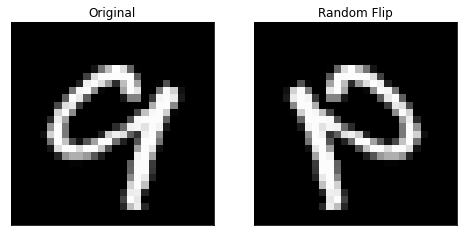

In [ ]:
flipped = RandomHorizontalFlip()(train)
plot([train, flipped], 1, 2, ['Original', 'Random Flip'], cmap='gray')

#### Random Color Swap

Now that you have learned how to implement a transformation class, let's build another one. Define a transformation which swaps the colors (in the gray scale image) with probability of $p$. For example, if the given image had a white colored number with a black background, it should output an image with black colored number and a white background.

**Hint:** for a given input $x$, you can concider the swapped color version of it as $x_{new} = m - x$ where $m$ is the maximum value in image $x$

In [ ]:
class RandomColorSwap:
    """same as RandomInvert in torch transforms"""
    
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, x):
        assert 2 <= x.ndim <= 3
  
        if torch.rand(1) < self.p:
            return torch.max(x) - x
        return x

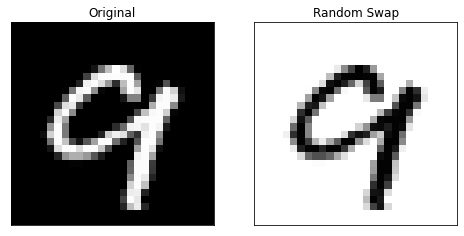

In [ ]:
swapped = RandomColorSwap()(train)
plot([train, swapped], 1, 2, ['Original', 'Random Swap'], cmap='gray')

### Evaluation of transformations

Now, let's apply these transformations on some images of our dataset. You can stack different transformation using `Compose`

In [ ]:
trans = transforms.Compose([
  RandomHorizontalFlip(p=0.7),
  RandomColorSwap()
])

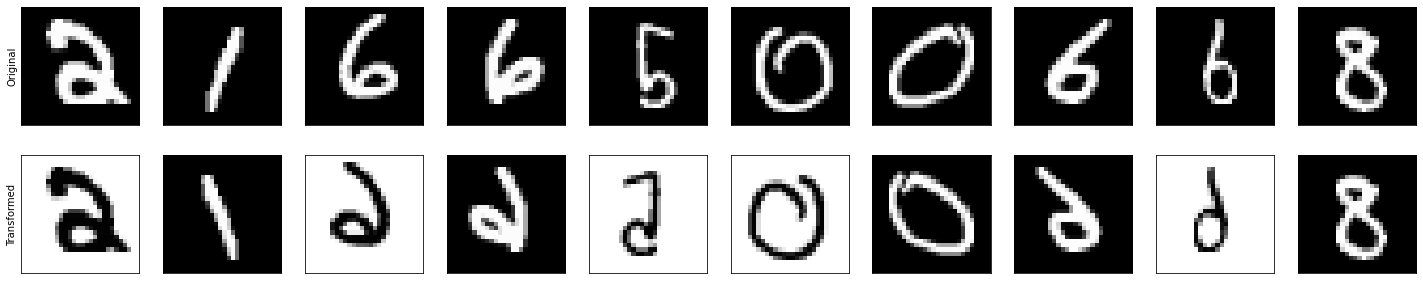

In [ ]:
num_imgs = 10
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(mnist_dataset), [num_imgs])):
    x, y = mnist_dataset[idx]
    axs[0, i].imshow(x[0], cmap='gray')
    axs[1, i].imshow(trans(x)[0], cmap='gray')
    for k in range(2):
        axs[k, i].set_yticks([])
        axs[k, i].set_xticks([])

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Transformed");

What we expect to see is that, some of them are fliped horizontally, some swapped in color, and some both.

## Dataset

In this section, we are going to implement a dataset class. Inside `torchvision.datasets` there are many Datasets that are already implemented and ready to use. But, in many situations it's necessary to implement one by your self.

Run the below cell to initialize our dataset

In [ ]:
dataset_path = "new_mnist"
init_mnist_subset_directories(mnist_dataset, dataset_path)

100%|██████████| 5000/5000 [00:34<00:00, 143.66it/s]


If you take a look at `new_mnist` directory which is created in the directory you are working in, you see that it contains 10 folders with names from `0` to `9` indicating the label of the images inside it. Inside each, some files with name `data_{number}.pth` exist. Each `.pth` file is an image.

Now you have to implement a Dataset on top of these files.
The methods that you should implement in a Dataset (as you can see in the code) is as described below:
- `__init__`: In our example assume that it only accepts `root_dir` and `transform` as it's parameters (You should apply the transformations before outputing the data)
- `__len__`: Should return the number of data in your dataset
- `__getitem__`: which receives an index, should return the data at the given index (which is a tuple here, containing image and the corresponding label) 

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform):
        self._data, self._labels = self._load_data(root_dir)
        self._transform = transform

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        image = self._transform(self._data[idx])
        return image, self._labels[idx]
    
    def _load_data(self, root_dir):
        data = []
        labels = []
        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            for pth_file in os.listdir(label_path):
                if pth_file.endswith('.pth'):
                    pth_path = os.path.join(label_path, pth_file)
                    data.append(torch.load(pth_path))
                    labels.append(int(label_dir))
        return data, labels

After you defined your dataset, let's use it.

In [ ]:
my_dataset = MNISTDataset(root_dir=dataset_path, transform=RandomColorSwap())
len(my_dataset)

5000

Visualize 10 samples (randomely) from your dataset with their labels

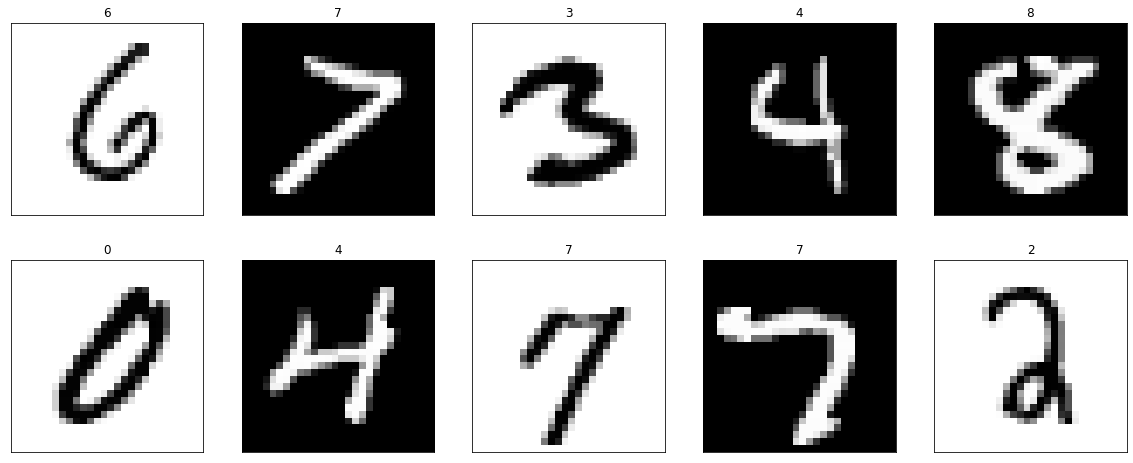

In [ ]:
idxs = np.random.randint(len(my_dataset), size=10)
data = [my_dataset[idx] for idx in idxs]
images = list(map(lambda img: img[0], data))
titles = list(map(lambda img: str(img[1]), data))
plot(images, 2, 5, titles, cmap='gray')

## MNIST Classification

### Model
Define your model (Based on what you have learned in the workshop). I highly encourage you to try different models with different layers in order to achieve a better accuracy

**Notice:** You cannot use convolution layers in your model 

In [ ]:
class DigitRecognizer(nn.Module):

    def __init__(self, in_features, hidden_size, num_classes):
         super().__init__()
         self.l1 = nn.Linear(in_features, hidden_size) 
         self.relu = nn.ReLU()
         self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
         out = self.l1(x)
         out = self.relu(out)
         out = self.l2(out)
         return out 

In [ ]:
in_features = 784 # 28 * 28
hidden_size = 500
num_classes = 10

model = DigitRecognizer(in_features, hidden_size, num_classes).to(device)
model

DigitRecognizer(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

### Dataset and Dataloader

Prepare datasets and dataloader for train/test. We use MNIST dataset that is already implemented inside `torchvision.datasets`.

 You need to split the `mnist_dataset` into `train_dataset` and `val_dataset`. 
 
 You can also define more transformations that you think it would help the training process **(Optional)**.

In [ ]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform_compose)
# Place your code here (1 points)
## Notice: Split mnist_dataset into train_dataset and val_dataset
train_size = int(0.9 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, (train_size, val_size))
# End of block for your code placement
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

### Criterion and Optimizer

you have to tune the `learning_rate` yourself (Based on your training process)

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train your model

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). You also need to store train/validation loss at each epoch in order to visualize them the after training is done.

In [ ]:
def train_epoch(
    model: nn.Module, 
    criterion: nn.Module, 
    optimizer: torch.optim.Optimizer, 
    dataloader: torch.utils.data.DataLoader
) -> int:
    train_loss = 0
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0

    model.train()
    for _, (images, labels) in enumerate(dataloader): 
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        epoch_loss = loss.item()

        predictions = outputs.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == labels).sum()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        train_loss += epoch_loss * dataloader.batch_size

    return train_loss, epoch_true, epoch_all

In [ ]:
def eval_epoch(
    model: nn.Module,
    criterion: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    test: bool
) -> int:
    wrong_ps, wrong_ls, wrong_pr = [], [], []
    val_loss = 0
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0

    model.eval()
    with torch.no_grad():
        for _, (images, labels) in enumerate(dataloader):
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_loss = loss.item()

            predictions = outputs.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == labels).sum()
      
            if test:
                wrong_ps += images[predictions != labels].tolist()
                wrong_ls += labels[predictions != labels].tolist()
                wrong_pr += predictions[predictions != labels].tolist()

            val_loss += epoch_loss * dataloader.batch_size
    
    if test:
        return val_loss, epoch_true, epoch_all, (wrong_ps, wrong_ls, wrong_pr)
    return val_loss, epoch_true, epoch_all

In [ ]:
num_epochs = 30
train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):

    # Place your code here (5 points)
    ## Hint: Loop throught train_loader, get images with their labels and train the model
    ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
    train_loss, train_true, train_all = train_epoch(model, criterion, optimizer, train_loader)
  
    # Place your code here (4 points)
    ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
    ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
    val_loss, val_true, val_all = eval_epoch(model, criterion, val_loader, False)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

    
    print(f'[Epoch {epoch}]\t'
        f'Train Loss: {train_loss:.4f}\t'
        f'Validation Loss: {val_loss:.4f}\t'
        f'Train Acc: {train_true * 100. / train_all:.2f}%\t'
        f'Val Acc: {val_true * 100. / val_all:.2f}%'
    )

[Epoch 0]	Train Loss: 0.5484	Validation Loss: 0.2979	Train Acc: 87.14%	Val Acc: 91.65%
[Epoch 1]	Train Loss: 0.2668	Validation Loss: 0.2348	Train Acc: 92.44%	Val Acc: 93.52%
[Epoch 2]	Train Loss: 0.2130	Validation Loss: 0.1978	Train Acc: 94.10%	Val Acc: 94.52%
[Epoch 3]	Train Loss: 0.1761	Validation Loss: 0.1684	Train Acc: 95.05%	Val Acc: 95.22%
[Epoch 4]	Train Loss: 0.1489	Validation Loss: 0.1486	Train Acc: 95.77%	Val Acc: 95.90%
[Epoch 5]	Train Loss: 0.1276	Validation Loss: 0.1335	Train Acc: 96.45%	Val Acc: 96.15%
[Epoch 6]	Train Loss: 0.1108	Validation Loss: 0.1182	Train Acc: 96.95%	Val Acc: 96.53%
[Epoch 7]	Train Loss: 0.0972	Validation Loss: 0.1118	Train Acc: 97.25%	Val Acc: 96.82%
[Epoch 8]	Train Loss: 0.0857	Validation Loss: 0.1035	Train Acc: 97.59%	Val Acc: 97.10%
[Epoch 9]	Train Loss: 0.0766	Validation Loss: 0.0960	Train Acc: 97.91%	Val Acc: 97.48%
[Epoch 10]	Train Loss: 0.0680	Validation Loss: 0.0940	Train Acc: 98.11%	Val Acc: 97.40%
[Epoch 11]	Train Loss: 0.0612	Validation L

#### Plot train/validation loss

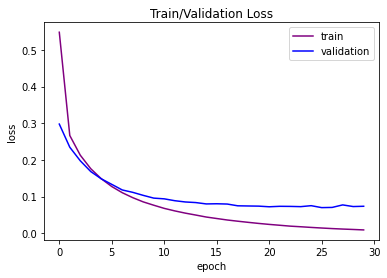

In [ ]:
def plot_loss(train_loss, val_loss, epochs):
    plt.plot(epochs, train_loss, color='purple', label='train')
    plt.plot(epochs, val_loss, color='blue', label='validation')
    plt.title(f'Train/Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

plot_loss(train_loss_arr, val_loss_arr, list(range(num_epochs)))

### Evaluation

Evaluate your model on test set. you have to report both loss and accuracy.

In order to get the full score of this section, you need to achieve an accuracy above $95\%$ and to get the extra points, your accuracy should be above $98\%$ 

**Notice:** You should use test set only for evaluation of your model.

In [ ]:
# Place your code here (4 points + 5 Extra)
test_loss, e_true, e_all, wrongs = eval_epoch(model, criterion, test_loader, True)
print(f'Loss: {test_loss / len(test_loader.dataset)} - Acc: {e_true * 100. / e_all:.2f}%')

Loss: 0.06748581080628792 - Acc: 98.05%


### Visualization of wrong prediction

Visualize $8$ samples (along with original label and model's prediction) from test set which are labeled wrong by your model

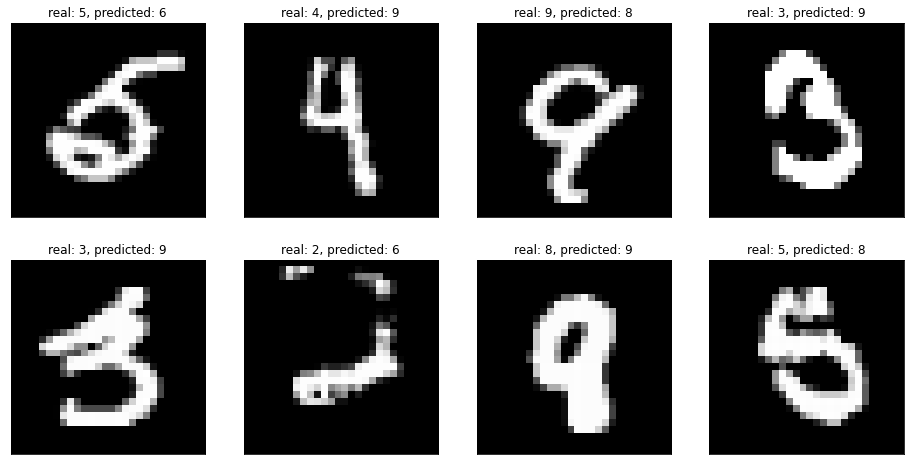

In [ ]:
# Place your code here (5 points)
idxs = np.random.randint(len(wrongs[0]), size=8)
samples = [np.array(wrongs[0][idx]).reshape(1, 28, 28) for idx in idxs]
labels = [f'real: {wrongs[1][idx]}, predicted: {wrongs[2][idx]}' for idx in idxs]
plot(samples, 2, 4, labels, cmap='gray')